## <mark>Modelling CBK Inflation Rate Data<mark>

1. 12-month inflation: normally considered as inflation rate, is defined as the percentage change in the monthly consumer price index (CPI). For example, the 12-month inflation rate for November 2017 is the percentage change in the CPI of November 2017 and November 2016.
2. Annual average inflation: is the percentage change in the annual average consumer price index (CPI) of the corresponding months e.g. November 2017 and November 2016.
3. In summary, "12-Month Inflation" focuses on the percentage change in the monthly CPI values for a specific month over a period of 12 months, while "Annual Average Inflation" compares the average CPI values for a specific month over a full year to the previous corresponding year's average CPI values for the same month. They represent different aspects of inflation measurement, capturing short-term changes and long-term trends, respectively.
4. Source: Kenya National Bureau of Statistics.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from scipy.stats.distributions import chi2
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('Inflation Rates.csv')
df

,Year,Month,Annual Average Inflation,12-Month Inflation
0,2011,November,12.82,19.72
1,2008,November,15.25,19.54
2,2011,December,14.02,18.93
3,2011,October,11.49,18.91
4,2008,October,14.13,18.74
...,...,...,...,...
219,2010,October,4.12,3.18
220,2007,February,5.55,3.02
221,2007,March,4.99,2.19
222,2007,May,4.47,1.96


In [3]:
df.dtypes

Year                          int64
Month                        object
Annual Average Inflation    float64
12-Month Inflation          float64
dtype: object

In [4]:
df.sort_values('Year', inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df['Year'].value_counts()

Year
2019    13
2005    12
2015    12
2022    12
2021    12
2020    12
2018    12
2017    12
2016    12
2014    12
2006    12
2013    12
2012    12
2011    12
2010    12
2009    12
2008    12
2007    12
2023     7
Name: count, dtype: int64

We see 13 records for 2019, lets see how that happened.

In [6]:
print(df[df['Year']==2019])

     Year      Month  Annual Average Inflation  12-Month Inflation
168  2019      March                      4.67                4.35
169  2019   November                      5.19                5.56
170  2019        May                      5.04                4.49
171  2019    January                      4.68                4.70
172  2019  September                      5.24                3.83
173  2019    October                      5.19                4.95
174  2019   December                      5.20                5.82
175  2019     August                      5.40                5.00
176  2019       June                      5.16                5.70
177  2019   February                      4.65                4.14
178  2019       July                      5.32                6.27
179  2019      April                      4.91                6.58
180  2019      April                      4.91                6.58


The entry for April is duplicated, we will drop it and check for any other duplicated rows

In [7]:
df[df.duplicated()]

,Year,Month,Annual Average Inflation,12-Month Inflation
180,2019,April,4.91,6.58


In [8]:
df.drop_duplicates(inplace=True)

We need to have our dates as index, I will convert them into one column and turn them into a date object and them make it the index.

In [9]:
# Create a new 'Date' column by combining 'Year' and 'Month' with day set to 1
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month']) + pd.offsets.MonthEnd(1)

# Drop the separate 'Year' and 'Month' columns we don't need them anymore
df.drop(['Year', 'Month'], axis=1, inplace=True)

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Now the 'Date' column serves as the index and is recognized as a date object
print(df)


C:\Users\HP\AppData\Local\Temp\ipykernel_2400\4109326685.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month']) + pd.offsets.MonthEnd(1)


            Annual Average Inflation  12-Month Inflation
Date                                                    
2005-09-30                     13.24                4.27
2005-08-31                     14.53                6.87
2005-11-30                     10.89                4.40
2005-02-28                     12.60               13.94
2005-03-31                     13.07               14.15
...                              ...                 ...
2023-04-30                      8.71                7.90
2023-01-31                      7.95                8.98
2023-07-31                      8.68                7.28
2023-05-31                      8.78                8.03
2023-06-30                      8.77                7.88

[223 rows x 2 columns]


In [10]:
df.sort_index(ascending=True, inplace=True)
df.head(15)

,Annual Average Inflation,12-Month Inflation
Date,,
2005-01-31,12.27,14.87
2005-02-28,12.60,13.94
2005-03-31,13.07,14.15
2005-04-30,13.76,16.02
2005-05-31,14.61,14.78
2005-06-30,15.10,11.92
2005-07-31,15.34,11.76
2005-08-31,14.53,6.87
2005-09-30,13.24,4.27


Lets set frequency for this data

In [11]:
df = df.asfreq('M')

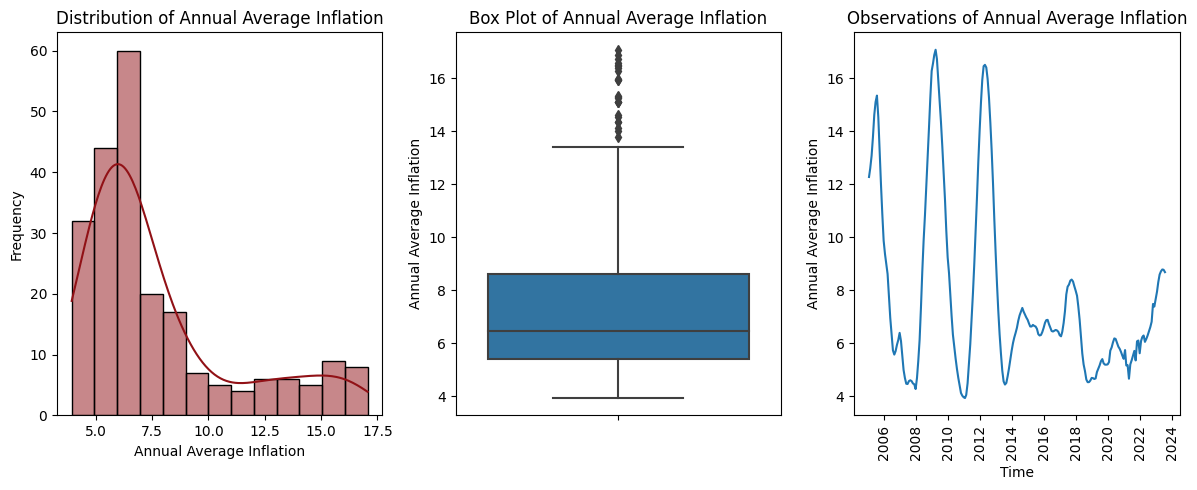

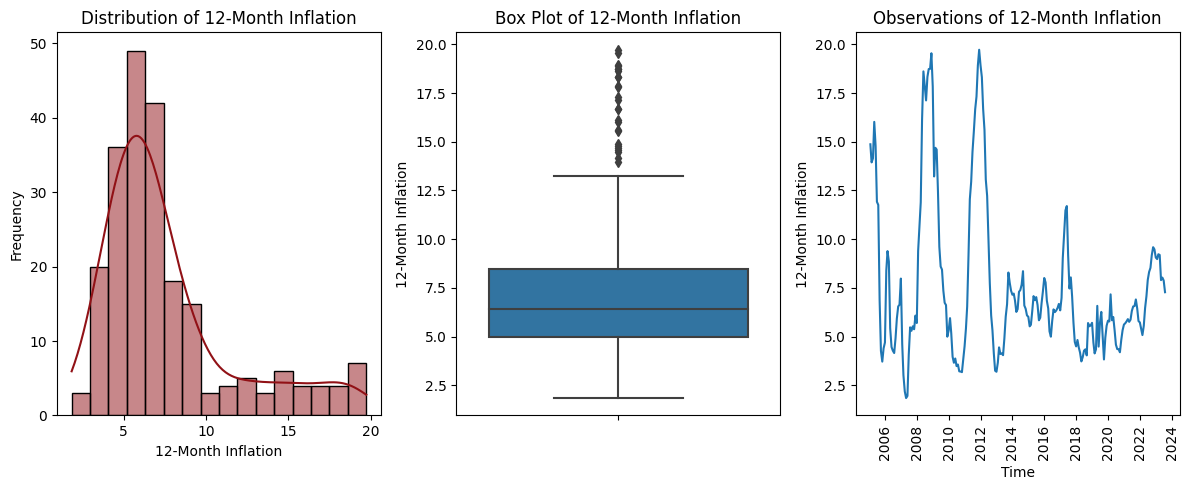

In [12]:
for col in df.columns:
     plt.figure(figsize=(12, 5))
     # Defining subplots
     # In index one of the subplot, we will have histogram
     plt.subplot(1, 3, 1)
     sns.histplot(data=df, x=col, kde=True, color = '#911116', line_kws={'color': '#911156'})
     plt.xlabel(col)
     plt.ylabel('Frequency')
     plt.title(f'Distribution of {col}')
     # The second index subplot will have boxplots
     plt.subplot(1, 3, 2)
     sns.boxplot(data=df, y=col)
     plt.ylabel(col)
     plt.title(f'Box Plot of {col}')
     # The third plot will display the observations
     plt.subplot(1,3,3)
     sns.lineplot(data=df, x=df.index, y=col)
     plt.xlabel('Time')
     plt.ylabel(col)
     plt.title(f'Observations of {col}')
     plt.xticks(rotation=90)
     # To make sure that no overlapping 
     plt.tight_layout()
     plt.show()


In [13]:
df.corr()

,Annual Average Inflation,12-Month Inflation
Annual Average Inflation,1.000000,0.622102
12-Month Inflation,0.622102,1.000000


Test for stationarity, these are percentage changes and therefore expected to be stationary, but we will confirm.

In [14]:
for col in df.columns:
    print('The p-value for ' + col + ' is: ' + str(adfuller(df[col])[1]))

The p-value for Annual Average Inflation is: 0.0014770508248099566
The p-value for 12-Month Inflation is: 0.007275993060870277


Both p-values for argumented Dicke-Fuller test are less than 0.05 hence we reject the null hypothesis of non-stationarity and therefore conclude that the data is stationary.

We will then check for seasonality we can not assume this since argumented Dickey-Fuller test checks only for the non-seasonal stationary.

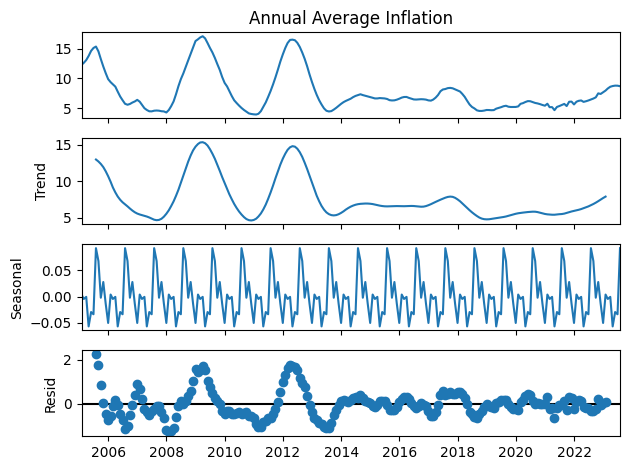

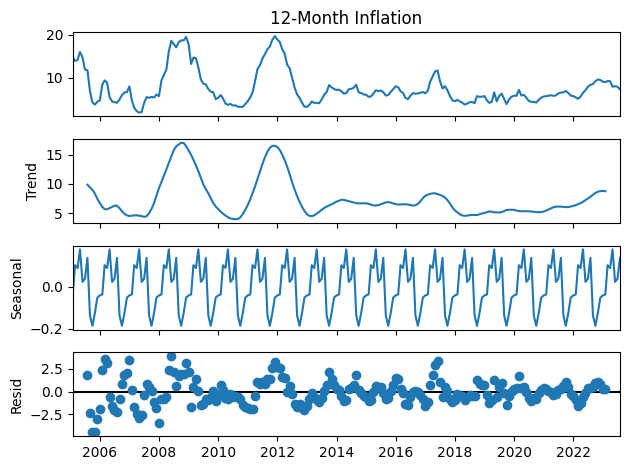

In [15]:
for col in df.columns:
    decomp = seasonal_decompose(df[col], period =12)
    decomp.plot()
    #plt.title(f'Decomposition of {col}')
    plt.show()


We see a seasonal trend for both columns in our data.

Lets see how this seasonality would look after the we take the first difference.

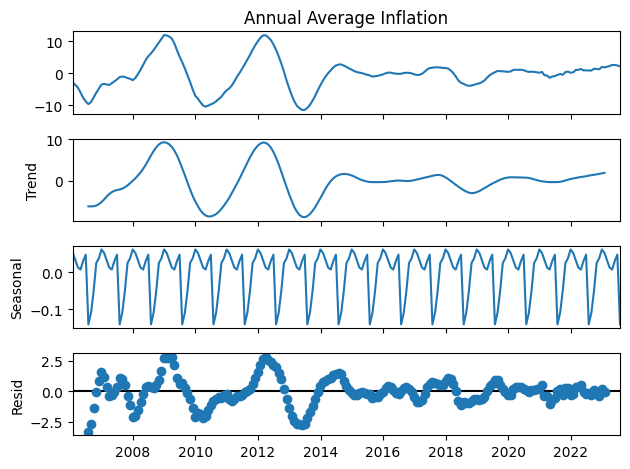

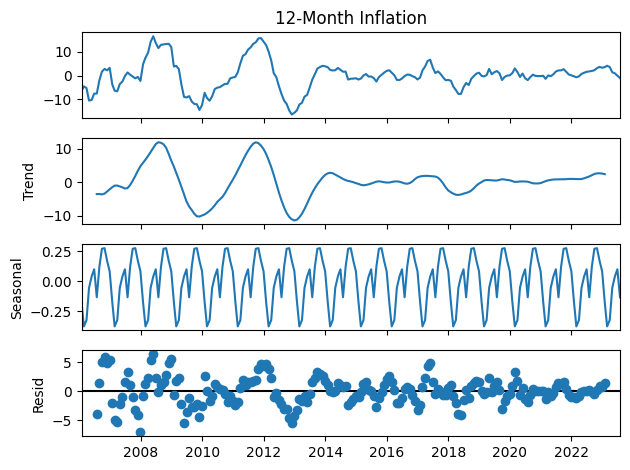

In [16]:
df_s = df.diff(12)
df_s.dropna(inplace=True)
for col in df_s.columns:
    decomp = seasonal_decompose(df_s[col], period =12)
    decomp.plot()
    #plt.title(f'Decomposition of {col}')
    plt.show()

The data still has strong seasonality

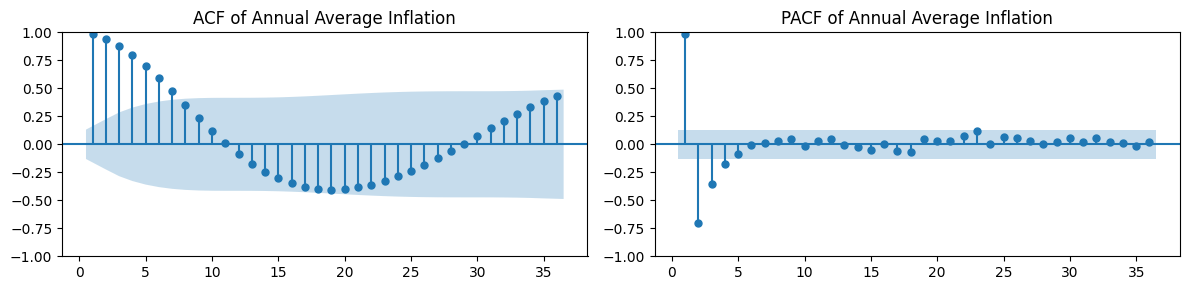

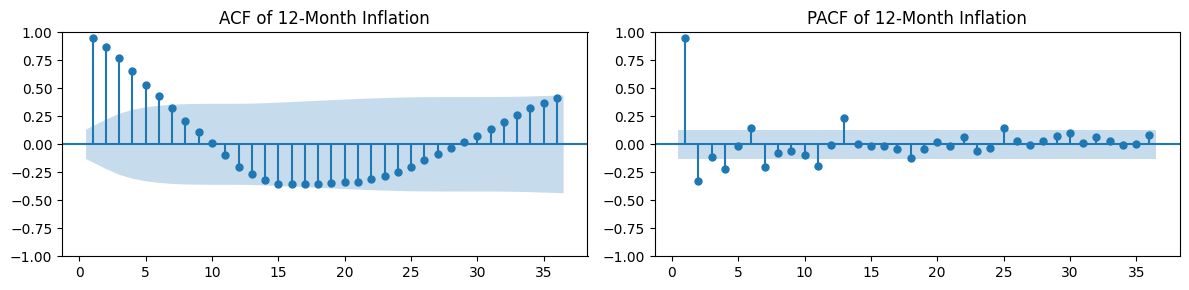

In [17]:
for col in df.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    
    # The first index subplot will have ACF
    plot_acf(df[col], lags=36, zero=False, ax=ax1)
    ax1.set_title(f'ACF of {col}')
    
    # The second index subplot will have PACF
    plot_pacf(df[col], lags=36, zero=False, ax=ax2)
    ax2.set_title(f'PACF of {col}')
    
    # To make sure that no overlapping 
    plt.tight_layout()
    plt.show()

In [18]:
df.columns

Index(['Annual Average Inflation', '12-Month Inflation'], dtype='object')

The ACF for Annual Average Inflation shows that Annual Average Inflation has an autocorrelation with the first 7 lags while the PACF shows only 4 lags are significantly different from zero

The ACF for 12-Month Inflation shows that 12-Month Inflation has an autocorrelation with the first 6 lags while the PACF shows that the first 4 lags are significantly different from zero but the third one.

Now we have analyzed our data and gained insights that will guide us when creating a model.

Let's start modelling!

In [19]:
df.isna().sum()

Annual Average Inflation    0
12-Month Inflation          0
dtype: int64

In [20]:
# Calculate the index to split at
split_index = int(len(df) * 0.8)

# Splitting the dataframe
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

We have seen from our analysis about the maximum values for p,q, we have also seen that d=0 and D=1. With this insights we can create a SARMAX model to predict the 12-Month Inflation given Annual Average inflation.

In [62]:
# Extract the target variable and exogenous variables
y = train_df['12-Month Inflation']
X = train_df['Annual Average Inflation']  # Pass exogenous variables as a DataFrame

# Fit the ARIMA model with exogenous variables
results = pm.auto_arima(y, seasonal=True, m=12, max_d=1,
                        stepwise=False, suppress_warnings=True, error_action='ignore',
                        max_p=6, max_q=6, max_Q=4, max_P=4, n_jobs=-1,
                        information_criterion='aic', trend='n')

print(results.summary())


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  178
Model:             SARIMAX(2, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood                -243.821
Date:                                 Wed, 09 Aug 2023   AIC                            497.642
Time:                                         00:58:36   BIC                            513.551
Sample:                                     01-31-2005   HQIC                           504.094
                                          - 10-31-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3383      0.062     21.455      0.000       1.216       1

Prob(Q) is higher than 0.05, hence we cannot reject the null hypothesis of no-autocorrelation. There could be other significant lags not captured here.

### Model Diagnostic

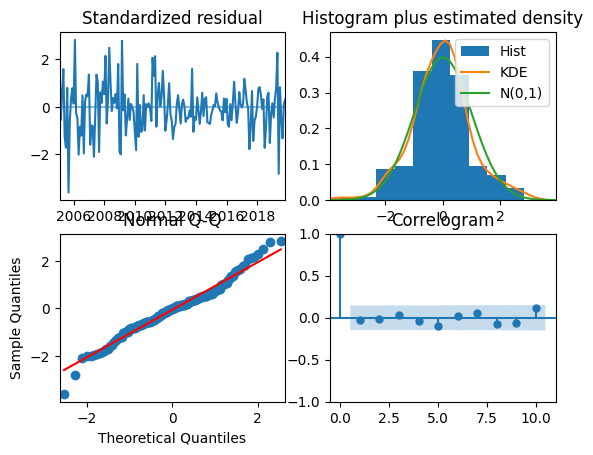

In [63]:
results.plot_diagnostics()
plt.show()

The above graphs looks pretty well.

Lets see the residual analysis.

<Figure size 1000x600 with 0 Axes>

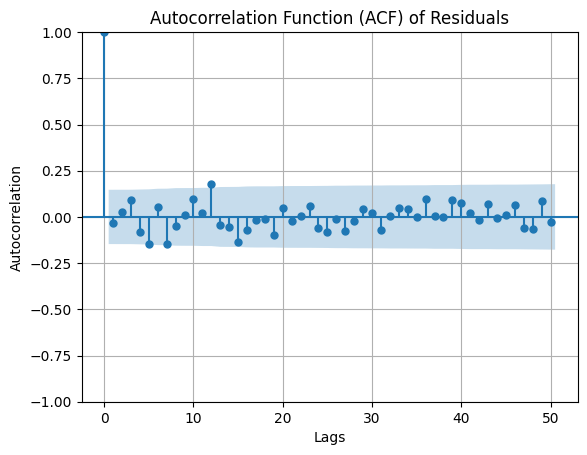

In [67]:
residuals = results.resid()

# Plot the ACF for the residuals
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=50, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.grid(True)
plt.show()

The residuals are almost white noise but not purely. There could be an improvement for our model.

Let me define a LLR test that you can use to compare your manual model selection.

In [42]:
def LLR_test (mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

I think if we included exogenous variable this model could perform more better. We can try that.